In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
perf_train= pd.read_csv('trainperf.csv')
perf_test= pd.read_csv('testperf.csv')

In [5]:
from sklearn.preprocessing import OrdinalEncoder

In [6]:
perf_train['referredby']= perf_train['referredby'].fillna(value='no one')

perf_test['referredby']= perf_test['referredby'].fillna(value='no one')

In [7]:
perf_train

,customerid,systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,referredby,good_bad_flag
0,8a2a81a74ce8c05d014cfb32a0da1049,301994762,12,2017-07-25 08:22:56.000000,2017-07-25 07:22:47.000000,30000.0,34500.0,30,no one,Good
1,8a85886e54beabf90154c0a29ae757c0,301965204,2,2017-07-05 17:04:41.000000,2017-07-05 16:04:18.000000,15000.0,17250.0,30,no one,Good
2,8a8588f35438fe12015444567666018e,301966580,7,2017-07-06 14:52:57.000000,2017-07-06 13:52:51.000000,20000.0,22250.0,15,no one,Good
3,8a85890754145ace015429211b513e16,301999343,3,2017-07-27 19:00:41.000000,2017-07-27 18:00:35.000000,10000.0,11500.0,15,no one,Good
4,8a858970548359cc0154883481981866,301962360,9,2017-07-03 23:42:45.000000,2017-07-03 22:42:39.000000,40000.0,44000.0,30,no one,Good
...,...,...,...,...,...,...,...,...,...,...
4363,8a858e6d58b0cc520158beeb14b22a5a,302003163,2,2017-07-30 09:19:42.000000,2017-07-30 08:18:30.000000,10000.0,13000.0,30,no one,Bad
4364,8a858ee85cf400f5015cf44ab1c42d5c,301998967,2,2017-07-27 15:35:47.000000,2017-07-27 14:35:40.000000,10000.0,13000.0,30,no one,Bad
4365,8a858f365b2547f3015b284597147c94,301995576,3,2017-07-25 16:25:57.000000,2017-07-25 15:24:47.000000,10000.0,11500.0,15,no one,Bad
4366,8a858f935ca09667015ca0ee3bc63f51,301977679,2,2017-07-14 13:50:27.000000,2017-07-14 12:50:21.000000,10000.0,13000.0,30,8a858eda5c8863ff015c9dead65807bb,Bad


In [8]:
perf_test.isnull().sum()

customerid      0
systemloanid    0
loannumber      0
approveddate    0
creationdate    0
loanamount      0
totaldue        0
termdays        0
referredby      0
dtype: int64

In [9]:
useless= ['customerid','systemloanid', 'approveddate', 'creationdate']
perf_train.drop(useless, axis=1, inplace=True)
perf_test.drop(useless, axis=1, inplace=True)

In [10]:
X= perf_train.drop(['good_bad_flag'], axis=1)
Y= perf_train['good_bad_flag']

In [11]:
X

,loannumber,loanamount,totaldue,termdays,referredby
0,12,30000.0,34500.0,30,no one
1,2,15000.0,17250.0,30,no one
2,7,20000.0,22250.0,15,no one
3,3,10000.0,11500.0,15,no one
4,9,40000.0,44000.0,30,no one
...,...,...,...,...,...
4363,2,10000.0,13000.0,30,no one
4364,2,10000.0,13000.0,30,no one
4365,3,10000.0,11500.0,15,no one
4366,2,10000.0,13000.0,30,8a858eda5c8863ff015c9dead65807bb


In [12]:
from sklearn.model_selection import train_test_split

In [13]:
x_train,x_test ,y_train, y_test= train_test_split(X,Y, test_size=0.1, random_state=0)

In [14]:
from sklearn.compose import make_column_selector as selector

numerical_columns_selector = selector(dtype_exclude=object)
categorical_columns_selector = selector(dtype_include=object)

numerical_columns = numerical_columns_selector(X)
categorical_columns = categorical_columns_selector(X)



In [15]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, RobustScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

numerical_preprocessor = RobustScaler()


categorical_preprocessor= OneHotEncoder(handle_unknown="ignore")

preprocessor = ColumnTransformer([
    ('ordinal-encoder', categorical_preprocessor, categorical_columns),
    ('standard-scaler', numerical_preprocessor, numerical_columns)])

C:\Users\ASUS\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\experimental\enable_hist_gradient_boosting.py:17: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  "Since version 1.0, "


In [16]:
preprocessor.fit_transform(X)

<4368x526 sparse matrix of type '<class 'numpy.float64'>'
	with 14166 stored elements in Compressed Sparse Row format>

In [17]:
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate, StratifiedShuffleSplit, cross_val_score
from xgboost import XGBClassifier
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import BaggingClassifier,RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier

In [18]:
def crs_val(algo):
  # run block of code and catch warnings
  import warnings
  with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    cv= StratifiedShuffleSplit(n_splits=10, random_state=42, test_size=0.2)
    model= Pipeline(steps=[('scale', preprocessor), ('sample', SMOTE(random_state=42)), ('model', algo)])
    result= cross_validate(model, x_train, y_train, cv=cv, scoring='accuracy', return_train_score=False)
    #print(result)
    return result['test_score']

In [19]:
algos= {'LogisticRegression':LogisticRegression(max_iter=2000),
       'RandomForestClassifier': RandomForestClassifier(random_state=0),
       'BaggingClassifier':AdaBoostClassifier(base_estimator=LogisticRegression(),random_state=0),
       'LGBMClassifier': LGBMClassifier(random_state=0),
       #'XGBClassifier': XGBClassifier(random_state=0),
       'ExtraTreesClassifier': ExtraTreesClassifier(random_state=0)
       }
for alg in algos.keys():
    score= crs_val(algos[alg])
    print(alg+': \n',score.mean(), ' +/- ',score.std())

LogisticRegression: 
 0.5040660736975858  +/-  0.0321654704572391
RandomForestClassifier: 
 0.6161372299872936  +/-  0.017601571294498478
BaggingClassifier: 
 0.5318932655654385  +/-  0.02851578786673196
LGBMClassifier: 
 0.6110546378653112  +/-  0.020936408642853007
ExtraTreesClassifier: 
 0.6130876747141041  +/-  0.01759973665083138


In [26]:
from scipy.stats import loguniform


class loguniform_int:
    """Integer valued version of the log-uniform distribution"""
    def __init__(self, a, b):
        self._distribution = loguniform(a, b)

    def rvs(self, *args, **kwargs):
        """Random variable sample"""
        return self._distribution.rvs(*args, **kwargs).astype(int)

In [23]:
from sklearn.model_selection import GridSearchCV
model= Pipeline(steps=[('scale', preprocessor), ('sample', SMOTE(random_state=42, )), ('classifier', RandomForestClassifier(random_state=0))])
cv= StratifiedShuffleSplit(n_splits=10, random_state=42, test_size=0.22)
param_grid = {
    'classifier__n_estimators': (100,200,300),
    'sample__k_neighbors':(3,5,7)
}
model_grid_search = GridSearchCV(
    model, param_grid=param_grid, n_jobs=-1, cv=cv
)
model_grid_search.fit(x_train, y_train)

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=10, random_state=42, test_size=0.22,
            train_size=None),
             estimator=Pipeline(steps=[('scale',
                                        ColumnTransformer(transformers=[('ordinal-encoder',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['referredby']),
                                                                        ('standard-scaler',
                                                                         RobustScaler(),
                                                                         ['loannumber',
                                                                          'loanamount',
                                                                          'totaldue',
                                                                          'termdays'])])),
       

In [24]:
cv_results = pd.DataFrame(model_grid_search.cv_results_)
cv_results[[
    "param_classifier__n_estimators",
    "param_sample__k_neighbors",
    "mean_test_score",
    "std_test_score",
    "rank_test_score"
]]

,param_classifier__n_estimators,param_sample__k_neighbors,mean_test_score,std_test_score,rank_test_score
0,100,3,0.598728,0.030624,9
1,100,5,0.610289,0.028475,4
2,100,7,0.618035,0.022154,1
3,200,3,0.598844,0.028818,8
4,200,5,0.608439,0.029411,5
5,200,7,0.617225,0.022645,3
6,300,3,0.599075,0.029145,7
7,300,5,0.608208,0.029463,6
8,300,7,0.617457,0.021925,2


In [25]:
cv_results = cross_validate(
    model_grid_search, X, Y, cv=cv, n_jobs=-1, return_estimator=True
)

In [27]:
cv_results = pd.DataFrame(cv_results)
cv_test_scores = cv_results['test_score']
print(
    "Generalization score with hyperparameters tuning:\n"
    f"{cv_test_scores.mean():.3f} +/- {cv_test_scores.std():.3f}"
)

Generalization score with hyperparameters tuning:
0.624 +/- 0.026


In [28]:
for cv_fold, estimator_in_fold in enumerate(cv_results["estimator"]):
    print(
        f"Best hyperparameters for fold #{cv_fold + 1}:\n"
        f"{estimator_in_fold.best_params_}"
    )

Best hyperparameters for fold #1:
{'classifier__n_estimators': 100, 'sample__k_neighbors': 7}
Best hyperparameters for fold #2:
{'classifier__n_estimators': 200, 'sample__k_neighbors': 7}
Best hyperparameters for fold #3:
{'classifier__n_estimators': 200, 'sample__k_neighbors': 7}
Best hyperparameters for fold #4:
{'classifier__n_estimators': 300, 'sample__k_neighbors': 7}
Best hyperparameters for fold #5:
{'classifier__n_estimators': 200, 'sample__k_neighbors': 7}
Best hyperparameters for fold #6:
{'classifier__n_estimators': 100, 'sample__k_neighbors': 7}
Best hyperparameters for fold #7:
{'classifier__n_estimators': 300, 'sample__k_neighbors': 7}
Best hyperparameters for fold #8:
{'classifier__n_estimators': 200, 'sample__k_neighbors': 5}
Best hyperparameters for fold #9:
{'classifier__n_estimators': 100, 'sample__k_neighbors': 7}
Best hyperparameters for fold #10:
{'classifier__n_estimators': 300, 'sample__k_neighbors': 7}


In [29]:
cv_results

,fit_time,score_time,estimator,test_score
0,433.870001,0.142999,GridSearchCV(cv=StratifiedShuffleSplit(n_split...,0.619147
1,436.033031,0.485815,GridSearchCV(cv=StratifiedShuffleSplit(n_split...,0.638918
2,440.738513,0.670187,GridSearchCV(cv=StratifiedShuffleSplit(n_split...,0.636837
3,442.436449,1.043052,GridSearchCV(cv=StratifiedShuffleSplit(n_split...,0.624350
4,430.379959,0.381001,GridSearchCV(cv=StratifiedShuffleSplit(n_split...,0.562955
5,425.810260,0.123998,GridSearchCV(cv=StratifiedShuffleSplit(n_split...,0.634755
6,434.561824,0.854113,GridSearchCV(cv=StratifiedShuffleSplit(n_split...,0.629553
7,429.725035,0.639057,GridSearchCV(cv=StratifiedShuffleSplit(n_split...,0.611863
8,230.917862,0.117995,GridSearchCV(cv=StratifiedShuffleSplit(n_split...,0.661811
9,235.130456,0.174270,GridSearchCV(cv=StratifiedShuffleSplit(n_split...,0.623309


In [33]:
pred=cv_results["estimator"][8].predict(perf_test)

(array([903.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 547.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

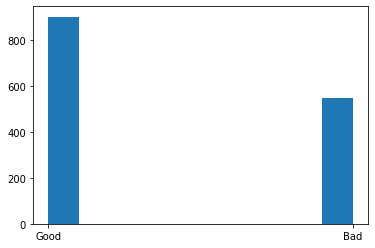

In [36]:
plt.hist(pred)

In [37]:
def submit():
    import datetime
    sub= pd.read_csv('SampleSubmission.csv')
    sub['good_bad_flag']=pred
    moment=datetime.datetime.now().strftime('%m%d%H%M%S')
    #print(moment)
    sub.to_csv(moment+'.csv', index=False)
    print(moment)
submit()

0323063301
